# Stock Sentiment Prediction using News Headline Data

We are attempting to assign sentiment to 1226258 news headlines from a leading australian news outlet, using this in combination with geospatial data providing intelligence for stock trading decisions, including using the sentiment data as input into a naive stock prediction of a australian ETF. 

It is worth noting we are not the first to think of or attempt this:

    - Hedge funds already use sentiment scores from news outlets to inform high frequency trading
    - Academic research has shown there is a existant correlation (albiet weak) between sentiment and individual stocks 
    - Several companies flagship product is news sentiment data for sale to the financial market 
    
    https://www.nature.com/articles/s41598-021-82338-6
    http://infotrie.com/finsents/
    https://stocksnips.net/

In [1]:
# import time
import re
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pickle


from collections import Counter
from matplotlib.pyplot import figure

import nltk

from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.models.callbacks import CallbackAny2Vec

import multiprocessing

from dateutil import parser
import statsmodels.formula.api as smf

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import spacy
from spacy import displacy
from textacy import preprocessing

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans

C:\Users\drpow\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\drpow\anaconda3\lib\site-packages\numpy\.libs\libopenblas.jpijnswnnan3ce6lli5fwsphut2vxmth.gfortran-win_amd64.dll
C:\Users\drpow\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Load and Inspect data

In [22]:
news = pd.read_csv('abcnews-date-text.csv', parse_dates=['publish_date'] )
news.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


## Light EDA to Scope out our data

In [25]:
plot_news = news.copy()

# Create a column that is the length of our headlines
plot_news['Avg_length'] = plot_news["headline_text"].apply(lambda x: np.mean([len(w) for w in x.split()]))

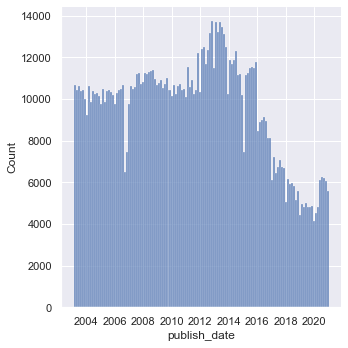

In [26]:
# lets get a sense for when these articles were published
sns.set(rc = {'figure.figsize':(15,8)})
sns.displot(data=plot_news, x= 'publish_date')

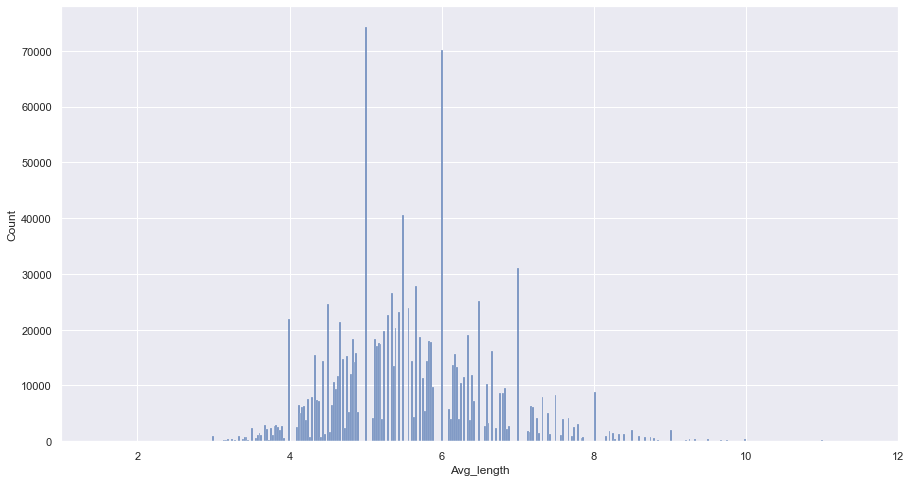

In [30]:
sns.set(rc = {'figure.figsize':(15,8)})
fig, ax = plt.subplots()
ax.set_xlim(1, 12)
sns.histplot(data=plot_news, x='Avg_length')

# Clean and Preprocess data

This data is already remarkably clean, in large part because it came from news headlines which are unlikely to have typos, partial words, or non standard characters such as emojis or HTML artifacts

In [31]:
def textacy_preprocess(messy_data):
    """
    Takes a dataframe and runs headline_text column through 
    textacy preprocessing pipeline and punctuation removing regex
    """
    cleaned_titles=[]
    #lets define a textacy preprocessing pipline that takes care of many basic regex operations for us 
    preproc = preprocessing.make_pipeline(
        preprocessing.replace.hashtags,
        preprocessing.replace.user_handles,
        preprocessing.replace.emojis,
        preprocessing.normalize.hyphenated_words,
        preprocessing.normalize.quotation_marks,
        preprocessing.remove.punctuation
    )

    for headline in messy_data['headline_text']:
        # Litte regex to remove any punctuation that textacy might miss
        headline = re.sub(r"[^A-Za-z0-9 ]",'',headline)
        cleaned_titles.append(preproc(headline))
        
    messy_data["headline_text"] = cleaned_titles 
    return(messy_data)

In [32]:
cleaned_news = textacy_preprocess(news)

# Mordecai
Mordecai is a geospatial library that maps references in unstructred free text to ISO geographic information
from https://github.com/openeventdata/mordecai 

   - It uses spaCy's named entity recognition to extract placenames from the text.
   
   
   - It uses the geonames gazetteer in an Elasticsearch index (with some custom logic) to find the potential coordinates of extracted place names.
   
- It uses neural networks implemented in Keras and trained on new annotated English-language data labeled with Prodigy to infer the correct country and correct gazetteer entries for each placename.



In order to work, Mordecai needs access to a Geonames gazetteer running in Elasticsearch. I have provided a dockerfile and Makefile that can implement this, though it is very slow, so I would reccomend skipping running this python file and using the sample I generated letting it run overnight


Usage: in top level directory:
1. Create a virtual enviroment (Note: It's strongly recommended that you run Mordecai in a virtual environment. The libraries that Mordecai depends on are not always the most recent versions and using a virtual environment prevents libraries from being downgraded or running into other issues:)
2. `pip3 install mordecai` (In virtual env)
3. `make develop` 
2. `python geoparsing.py` or run magic cell below


**Comenting out lines that break continuity if running notebook from start to finish**

In [ ]:
#%run geoparsing.py

## Sentiment by Country 

Since we do not have enough time to run all the data through mordecai for use in prediction, however we can still study the sentiment by country identified to inform global investment strategies.

This analysis can only be run once sentiment is calculated below, but I am leaving it here within the mordecai section for consistency 

We will only study the sentiment where there are at least 200 articles for a predicted country

In [33]:
# read in mordecai sample we produced offline
mordecai_news = pd.read_csv('abcnews-date-text-mordecai_part_300000.csv')
#read in our kmeans sentiment 
kmeans_sent = pd.read_csv('kmeans_sentiment_df.csv')
mordecai_news.drop(columns=['Unnamed: 0'], inplace=True)

#combine sentiment and mordecai 
mordeca_kmeans_sent = mordecai_news.merge(kmeans_sent, how = 'left', left_index =True, right_index=True)

In [34]:
# group by countries
top_countries = mordeca_kmeans_sent.groupby('country_predicted')\
    .agg({'sentiment_rate':['mean', 'count']})

# retain only countries with +200 mentions
top_countries = top_countries[top_countries['sentiment_rate']['count'] >200]

# map columns back to remove multi-index
top_countries.columns = list(map('_'.join, top_countries.columns.values))
top_countries.reset_index(inplace=True)



In [35]:
top_countries.head()

,country_predicted,sentiment_rate_mean,sentiment_rate_count
0,AFG,8.843525,364
1,ATA,11.980172,621
2,AUS,2.081081,16731
3,BGD,16.687547,304
4,BRA,17.244924,369


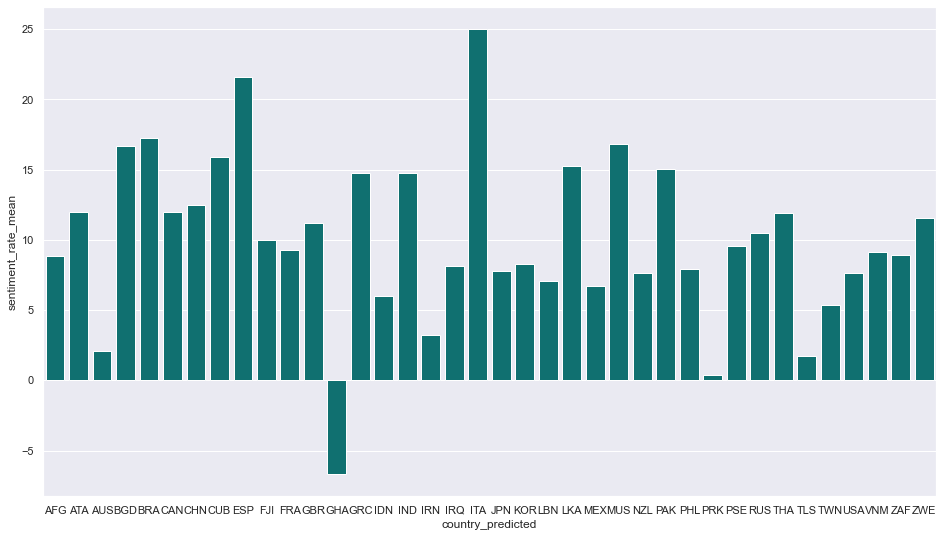

In [37]:
rcParams['figure.figsize'] = 16,9
sns.barplot(data= top_countries, y='sentiment_rate_mean', x='country_predicted', color ='teal' )

We can see that there are several countries that have particularly bad sentiment, including ghana, north korea, and Timor-Leste, while western european countries lead the pack inclugind italy, and spain

# Unsupervised Sentiment Analysis
In real world applications we are not always lucky enough to have to labeled data or have the time/resources to label a sufficient portion, 

For sentiment analysis there are several approaches that we will compare: 

    - CLustering Approach (https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483) 
    
    - Vader (https://medium.com/analytics-vidhya/sentiment-analysis-with-vader-label-the-unlabeled-data-8dd785225166)
    
    - BERT (https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
        
  
Lets make sure to make scores go between -1 and 1 so we can compare across methodologies 

## Bert

In [49]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis', "distilbert-base-uncased-finetuned-sst-2-english")

In [50]:
classifier('cemeteries miss out on funds')

[{'label': 'NEGATIVE', 'score': 0.9995111227035522}]

In [ ]:
# Bert sentiment classifier is extrodinarily easy, but slow, we will use this opportuynity for a state save and will write
# the dataframe to disk with the sentiment 
confidence = []
for headline in news['headline_text']:
    confidence.append(classifier(headline))
news['BERT_sentiment'] = confidence

# lets write out the dat
news.to_csv('abcnews-date-text_bert.csv')

## K-means method 

An alternative to BERT is a very unusual method that uses K-means on embeddings to group our words into two clusters, we then use a heuristic to assign reasonable sentiment labels to the two clusters as eithier positive or negative words, we can then generate the sentiment of a given vector by taking the average of the word sentiment scores. 

I hypothesize this may work well for our particular dataset due to the domain specific language in news, and the many references to entities that may not appear often in other text. 

Cons of this approach: 
    - We treat our inferred labels as ground truth when creating our classification model
    - We end up with a bag of words model, since we average the vector to get a headline sentiment score
    
    
Inspired by:https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483



### Tokenize our Titles
Be sure to only use the tokenize function of spacy to save on compute

In [11]:
from spacy.lang.en import English
nlp = English()
tokenizer = nlp.tokenizer
tokens = []
# for each headline lets tokenize the sentence
for doc in cleaned_news['headline_text']: 
    temp_tokens = tokenizer(doc)
    title_tokens = []
    # now lets break the sentence into indivual tokens
    for token in temp_tokens:
        title_tokens.append(token.text)
    tokens.append(title_tokens)
tokens

[['aba', 'decides', 'against', 'community', 'broadcasting', 'licence'],
 ['act', 'fire', 'witnesses', 'must', 'be', 'aware', 'of', 'defamation'],
 ['a', 'g', 'calls', 'for', 'infrastructure', 'protection', 'summit'],
 ['air', 'nz', 'staff', 'in', 'aust', 'strike', 'for', 'pay', 'rise'],
 ['air', 'nz', 'strike', 'to', 'affect', 'australian', 'travellers'],
 ['ambitious', 'olsson', 'wins', 'triple', 'jump'],
 ['antic', 'delighted', 'with', 'record', 'breaking', 'barca'],
 ['aussie', 'qualifier', 'stosur', 'wastes', 'four', 'memphis', 'match'],
 ['aust', 'addresses', 'un', 'security', 'council', 'over', 'iraq'],
 ['australia', 'is', 'locked', 'into', 'war', 'timetable', 'opp'],
 ['australia', 'to', 'contribute', '10', 'million', 'in', 'aid', 'to', 'iraq'],
 ['barca', 'take', 'record', 'as', 'robson', 'celebrates', 'birthday', 'in'],
 ['bathhouse', 'plans', 'move', 'ahead'],
 ['big', 'hopes', 'for', 'launceston', 'cycling', 'championship'],
 ['big', 'plan', 'to', 'boost', 'paroo', 'water',

In [12]:
# This will log our log loss which will be very useful for picking number of epochs strange to me its not default behavior
# callback class inspired by https://stackoverflow.com/questions/54888490/gensim-word2vec-print-log-loss

# init callback class
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

### Buid our model, define the vocab, and train it on our corpus

We will create a word2vec model to train our embeddings specific to our corpus

**Hyper Paramater Choices**

    - We want complex embeddings since our headlines are short so we will choose 300 for size,

    - We dont want words that only appear once for sparsity reasons so we set our min_count to 3 
    
    - Fairly large alpha that decays to 0.0007 which hopefully will work well many short documents that may be repitious

    - We also want a relatively small window because our headlines are so short also because we dont want a very domain specific embedding per: 


*some research has suggested that using a larger window tends to position the final vectors in a way that's more sensitive to topical/domain similarity, while a smaller window value shifts the word-neighborhoods to be more syntactic/functional drop-in replacements for each other.*



In [13]:
%%time 
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers=multiprocessing.cpu_count()-1)


w2v_model.build_vocab(tokens, progress_per=50000)
w2v_model.train(tokens, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1, compute_loss=True, 
                     callbacks=[callback()])


Loss after epoch 0: 828865.625
Loss after epoch 1: 796620.25
Loss after epoch 2: 750106.375
Loss after epoch 3: 697380.0
Loss after epoch 4: 681187.25
Loss after epoch 5: 597405.5
Loss after epoch 6: 505637.5
Loss after epoch 7: 483681.0
Loss after epoch 8: 542361.0
Loss after epoch 9: 498355.0
Loss after epoch 10: 498202.5
Loss after epoch 11: 424903.5
Loss after epoch 12: 450024.0
Loss after epoch 13: 455409.5
Loss after epoch 14: 499730.0
Loss after epoch 15: 460938.0
Loss after epoch 16: 455596.0
Loss after epoch 17: 424857.0
Loss after epoch 18: 453123.0
Loss after epoch 19: 455859.0
Loss after epoch 20: 422704.0
Loss after epoch 21: 441647.0
Loss after epoch 22: 409431.0
Loss after epoch 23: 409963.0
Loss after epoch 24: 381110.0
Loss after epoch 25: 421307.0
Loss after epoch 26: 438479.0
Loss after epoch 27: 424387.0
Loss after epoch 28: 396021.0
Loss after epoch 29: 415686.0
Wall time: 1min 45s


(88628323, 241046820)

### Retrain with fewer epochs 

In [14]:
# we can observe a "jittering" of loss up and down starting after around epoch 8, so we will set our epochs to 7 to be safe
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers=multiprocessing.cpu_count()-1)

w2v_model.build_vocab(tokens, progress_per=50000)

w2v_model.train(tokens, total_examples=w2v_model.corpus_count, epochs=8, report_delay=1, compute_loss=True, 
                     callbacks=[callback()])
w2v_model.save('word2vec.model')

Loss after epoch 0: 855117.3125
Loss after epoch 1: 778662.8125
Loss after epoch 2: 783383.625
Loss after epoch 3: 732482.25
Loss after epoch 4: 718728.0
Loss after epoch 5: 619702.0
Loss after epoch 6: 565409.0
Loss after epoch 7: 552642.0


### Run our embeddings through KMeans to find similar words

While kmeans cannot accept different distance metrics, we can simply normalize our vectors which then makes euclidean distance proporional to cosine distance 
https://stackoverflow.com/questions/46409846/using-k-means-with-cosine-similarity-python

In [22]:
# snag our word embeddings from our word2vec model  
word_vectors= w2v_model.wv

#create a two cluster kmeans that we will use to assign initial sentiment 
km = KMeans(n_clusters=2, max_iter=500, random_state=True, n_init=50).fit(X=\
                                                sklearn.preprocessing.normalize(word_vectors.vectors.astype('double')))

#grab the top words from the index 1 cluster
word_vectors.similar_by_vector(km.cluster_centers_[1], topn=30, restrict_vocab=None)

[('nationally', 0.9961749911308289),
 ('economically', 0.9958812594413757),
 ('calderwood', 0.9953569769859314),
 ('dividing', 0.9950661659240723),
 ('submitted', 0.9944886565208435),
 ('wastage', 0.9944350719451904),
 ('foodbowl', 0.994354248046875),
 ('detrimental', 0.9942970871925354),
 ('homelands', 0.9936981797218323),
 ('fortnightly', 0.9935835599899292),
 ('amalgamate', 0.993540346622467),
 ('electranet', 0.9935305714607239),
 ('accomodation', 0.9935132265090942),
 ('biosolids', 0.9933958053588867),
 ('enhanced', 0.9933798313140869),
 ('contributors', 0.993369996547699),
 ('redirected', 0.9933401942253113),
 ('kangaloon', 0.9933239817619324),
 ('supplementary', 0.9932680726051331),
 ('vcoss', 0.9932526350021362),
 ('infill', 0.9932491183280945),
 ('freehold', 0.9931695461273193),
 ('hwe', 0.9930689930915833),
 ('sanitary', 0.9929832816123962),
 ('glitches', 0.992636501789093),
 ('commercially', 0.9925680160522461),
 ('dnr', 0.992497980594635),
 ('problematic', 0.9924957156181335

In [24]:
word_vectors.similar_by_vector(km.cluster_centers_[0], topn=20, restrict_vocab=None)

[('salma', 0.9982630014419556),
 ('witches', 0.9981409907341003),
 ('flattered', 0.9981108903884888),
 ('ranting', 0.9980683922767639),
 ('mandy', 0.9980679154396057),
 ('priebus', 0.9980022311210632),
 ('nicki', 0.9979618787765503),
 ('bookstores', 0.9979469776153564),
 ('pal', 0.997905969619751),
 ('blackburns', 0.9978662133216858),
 ('zebras', 0.9978460669517517),
 ('reince', 0.9977982640266418),
 ('trolled', 0.9977729320526123),
 ('charlize', 0.9977412819862366),
 ('seamus', 0.9977098107337952),
 ('gero', 0.9976457357406616),
 ('domingo', 0.997614324092865),
 ('blond', 0.9976021647453308),
 ('griezmann', 0.997589111328125),
 ('tussauds', 0.9975794553756714)]

### Assign sentiment to clusters

This is a significantly hard heursitic to apply, as neithier clusters top words are overwhelmingly positive or negative, I have two theories for this, firstly the formal language of news is intrinsically non-partisan, secondly the distances are so close (top 20 all > 99.6) we can also see that these are not general words, indeed they are very specific. 

Despite all this, the index cluster 1 seems to be more negative (problematic,crippling,detrimental) than index 0

In [26]:
positive_cluster_index = 0
positive_cluster_center = km.cluster_centers_[positive_cluster_index]
negative_cluster_center = km.cluster_centers_[1-positive_cluster_index]


In [27]:
# Create a dataframe to map KMeans cluster labels to words
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: km.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])


In [28]:
# Apply sentiment score as function of the words closeness to the centroid
words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(km.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

sent_dict = words[['words', 'sentiment_coeff']].values

In [48]:
sent_dict = dict(sent_dict)
sent_dict

{'to': -0.27877941674470785,
 'in': 0.42047542474808824,
 'for': -0.32205798513028455,
 'of': 0.40814534169486477,
 'on': -0.461044929667621,
 'the': 0.37544241367736936,
 'over': 0.3162248275135506,
 'police': 0.2527767120552989,
 'at': 0.48648335182832264,
 'with': 0.4037201700941474,
 'after': 0.3676406369912481,
 'new': -0.4514102839890369,
 'man': 0.23308390690394154,
 'a': 0.3934428456735228,
 'and': 0.450484024801153,
 'as': 0.4126300411192354,
 'says': -0.33714394827725985,
 'from': 0.5192206607218054,
 'up': -0.4153852913373491,
 'by': 0.4571276492702987,
 'us': 0.2880429706188237,
 'out': 0.41352122187445695,
 'court': 0.2585718343804253,
 'be': -0.3360354480217852,
 'govt': -0.31395869115473557,
 'council': -0.2770179661749154,
 'more': -0.35462874481243184,
 'australia': 0.3505978863597092,
 'nsw': -0.3604229760439678,
 'not': -0.3379208234104048,
 'interview': 0.17400803996435488,
 'fire': -0.2825822111345321,
 'nt': -0.29918250593833595,
 'australian': 0.42629763321120945

### TF-IDF 
This method relies on assigning similarity for each document with the doc product of its tf-idf matrix and the inffered sentiment from the KMeans clustering, now we construct the TFIDF matrix and find the value for each unque word

In [57]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, norm=None)
tfidf.fit(cleaned_news['headline_text'])
features = pd.Series(tfidf.get_feature_names())
transformed = tfidf.transform(cleaned_news['headline_text'])



C:\Users\drpow\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [58]:
def create_tfidf_dictionary(x, transformed_file, features):
    """""
    Each input document is assigned a dictionary with sentiment for all tokens
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    """""
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    """""
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    """""
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], word_tokenize(x.headline_text)))



In [59]:
replaced_tfidf_scores = cleaned_news.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)#this step takes around 3-4 minutes minutes to calculate

### Replace each document with dot product of TF-IDF and Kmeans Sentiment Coefficient

In [30]:
def replace_sentiment_words(word, sentiment_dict):
    '''Lookup Sentiment for a given word, if out of vocab, reuturn 0'''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [54]:
# replace each word with its adjusted sentiment score
all_sentiments=[]
for headline in cleaned_news['headline_text']: 
    headline_sent = []
    for word in word_tokenize(headline): 
        headline_sent.append(replace_sentiment_words(word, sent_dict))
    all_sentiments.append(headline_sent)

replaced_closeness_scores = pd.Series(all_sentiments)

Merge the sentiment and tfidf scores and compute the dot matrix for a final sentiment rate calculation

In [62]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, cleaned_news.headline_text]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')


AttributeError: 'DataFrame' object has no attribute 'sentiment'

In [65]:
replacement_df.head(5)

,sentiment_coeff,tfidf_scores,sentence,sentiment_rate,prediction
0,"[-1.1709900105044573, -0.6654634405530948, 0.3...","[11.049186715732196, 9.995598108438042, 5.6846...",aba decides against community broadcasting lic...,-11.411639,0
1,"[-0.4235783909495117, -0.2825822111345321, 0.2...","[6.286045662870665, 5.389047297004651, 8.12785...",act fire witnesses must be aware of defamation,-8.050290,0
2,"[0.3934428456735228, -0.332376021179608, -0.37...","[4.735091922585275, 8.488601001558433, 5.87463...",a g calls for infrastructure protection summit,-12.179778,0
3,"[-0.35678723784011607, 0.5850504709502775, -0....","[6.845339285854847, 6.954213420386585, 7.01611...",air nz staff in aust strike for pay rise,-9.358000,0
4,"[-0.35678723784011607, 0.5850504709502775, -0....","[6.845339285854847, 6.954213420386585, 6.79210...",air nz strike to affect australian travellers,-6.037280,0


In [64]:
replacement_df.to_csv('kmeans_sentiment_df.csv')

# Modeling stock prices 

https://www.ishares.com/us/products/239607/ishares-msci-australia-etf

We will be using our daily sentiment values to aid in predictions for an australian companies ETF, in combination with other technical indicators a daily trader would use.

Since we are assuming our company makes trades daily, we will not shift our sentiment data back a day, while this does make the faulty assumption that all news come out before trading session for a day, it is more realistic as the news data that comes out throughout a day does plausibly make an impact on closing price

To evaluate the usefullness of the daily sentiment we will use sharpe ratio, defined below to see if our portfolio actually benefits from the inclusion of daily sentiment in our predictive models

## Read in sentiment data and prep for prediction

In [2]:
# read in our data saved from both sentiment models and mordecai data
bert_sent = pd.read_csv('abcnews-date-text_bert.csv', parse_dates = ['publish_date'])
kmeans_sent = pd.read_csv('kmeans_sentiment_df.csv')
news = pd.read_csv('abcnews-date-text.csv', parse_dates=['publish_date'] )

#assign the publish date back to the kmeans dataset 
kmeans_sent['publish_date'] = news['publish_date']

In [3]:
# calculate the KMEANS mean daily sentiment for news
kmeans_daily = kmeans_sent.groupby('publish_date').agg({'sentiment_rate':np.std}).reset_index()
kmeans_daily.rename(columns= {'publish_date':'Date'}, inplace=True)

In [4]:
# Parse bert sentiment with -1 being max negative sentiment and 1 being max positive sentiment 
# in retrospect should have done this while creating sentiment, this is wonky
sent_converted = []
for sent in bert_sent['BERT_sentiment']:
    sent_list = sent.split(',')
    label = sent_list[0][12:13]
    sent_val = float(sent_list[1][10:15])
    # if negative sentiment, * -1 to make sentiment negative
    if label == 'N':
        sent_converted.append(-sent_val)
    elif label == 'P':
        sent_converted.append(sent_val)
    else: 
        print('couldnt find sentiment label')
        break
bert_sent['normalized_sentiment'] = sent_converted

In [5]:
# calculate the BERT mean daily sentiment for news
bert_daily = bert_sent.groupby('publish_date').agg({'normalized_sentiment':np.std}).reset_index()
bert_daily.rename(columns= {'publish_date':'Date'}, inplace=True)

In [6]:
bert_daily.head()

,Date,normalized_sentiment
0,2003-02-19,0.901369
1,2003-02-20,0.914986
2,2003-02-21,0.908745
3,2003-02-22,0.918795
4,2003-02-23,0.938202


## Read in finance data and create financial variables 

**Financial Variables of interest**

* vwretd : Value-Weighted Return (includes distributions) (vwretd)
* vwretx : Value-Weighted Return (excluding dividends) (vwretx)
* ewretd : Equal-Weighted Return (includes distributions) (ewretd)
* ewretx : Equal-Weighted Return (excluding dividends) (ewretx)
* sprtrn : Return on S&P Composite Index (sprtrn)

In [7]:
# Reading EWA (Daily returns) & EWA CRSP (Return Statistics) data
ewa = pd.read_csv('EWA.csv').drop(['Open','High','Low','Close'],axis=1)
ewa_crsp=pd.read_csv('EWA_CRSP.csv')[['date','vwretd','vwretx','ewretd','ewretx','sprtrn']]

# Parsing dates for the two dataframes
ewa_crsp['date']=[parser.parse(str(i))for i in ewa_crsp['date']]
ewa['Date']=[parser.parse(i)for i in ewa['Date']]

# Creating a pct change return in the EWA dataframe
ewa['ret']=ewa['Adj Close'].pct_change()
ewa.dropna(inplace=True)

# Setting date as index for the two dataframes
ewa.set_index('Date',inplace=True)
ewa_crsp.set_index('date',inplace=True)

# Merging the two dataframes into one
comb_ewa=ewa.merge(ewa_crsp,left_index=True,right_index=True).drop('Volume',axis=1)

# Preparing risk free return data
IRX = pd.read_csv('^IRX.csv').dropna()
IRX['Date']=[parser.parse(i)for i in IRX['Date']]
IRX['rf_ret']=IRX['Adj Close'].pct_change()
IRX['rf_ret']=IRX['rf_ret']/360
IRX = IRX[['Date','rf_ret']]
IRX.set_index('Date',inplace=True)

#Making the dataframes into one and making a excess return column and five period average return column
comb_ewa = comb_ewa.merge(IRX,left_index=True,right_index=True)
comb_ewa['ex_ret'] = comb_ewa['ret']-comb_ewa['rf_ret']
comb_ewa['five_MA']=comb_ewa['ex_ret'].rolling(5).mean()
comb_ewa.drop('Adj Close',axis=1,inplace=True)
comb_ewa.dropna(inplace=True)

In [8]:
#prep financial dataframe for merging
comb_ewa.reset_index(inplace=True)
comb_ewa.rename(columns= {'index':'Date'},inplace=True)

## Financial Modeling
When possible, it is generally good to model based on the actual business metric of interst, in our case that is sharpe ratio 

To compare if our sentiment methods produce higher returns, we will use the Sharpe ratio. Sharpe ratio is a metric to compare portfolios or different strategies by seeing how much excess return was achieved over the given volatility.

![alt text](sharpe-ratio-formula.svg "Title")


In [9]:
def get_sharpe(X, mod):
    """calculates and returns sharpes ratio"""
    # Lets get sharpe ratio for this run
    pred_ewa=X.copy()

    # get predictions to buy or sell, will use this to calculate sharpe ratio 
    pred_ewa['pred']=[mod.predict(X.loc[i])[0] for i in list(X.index)]
    pred_ewa.loc[pred_ewa['pred']>pred_ewa['five_MA'],'Trading Signal']='Buy'

    # determine when to buy based on model, get expected returns
    stats=pred_ewa.loc[pred_ewa['Trading Signal']=='Buy'].describe()['ex_ret']

    #calculate and show sharpe ratio
    sharpe = stats['mean']/stats['std']*np.sqrt(12)

    return(sharpe)

In [10]:
def lin_reg(dv=str, rv = list, data=pd.DataFrame):
    """perform linear regression on a given dataframe"""
    columns_list=[]
    for i in list(data.columns):
        if (i != dv)&(i not in rv):
            columns_list.append(i)
    print(columns_list)
    form=f'{dv} ~ '
    for i in columns_list:
        i = str(i)
        if columns_list[len(columns_list)-1]!=i:
            form += i+'+'
        else:
            form += i
    model = smf.ols(form,data=data).fit()
    model.summary()
    return model

In [11]:
sharpe_scores = {} 

### Baseline model, linear regression of expected return only with technical indicators

In [12]:
# Combine our sentiment data and financial data
kmeans_daily_fin = kmeans_daily.merge(comb_ewa, how ='inner', on = 'Date')
kmeans_daily_fin.set_index('Date', inplace=True)

In [13]:
#check for nulls 
np.where(kmeans_daily_fin.isnull()==True)

#there is a day with no sentiment, lets remove it
kmeans_daily_fin.dropna(inplace=True)

In [14]:
# linear regression without daily sentiment
mod = lin_reg('ex_ret',['sentiment_rate', 'five_MA','rf_ret','ret'],kmeans_daily_fin)
mod.summary()

['vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ex_ret   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     599.9
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:43:04   Log-Likelihood:                 9316.0
No. Observations:                3237   AIC:                        -1.862e+04
Df Residuals:                    3231   BIC:                        -1.858e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0003      0.000     -0.845      0.398      -0.001       0.000
vwretd         1.1416      3.529      0.323      0.746      -5.778       8.062
vwretx         1.2033      3.544      0.340      0.734      -5.746       8.152
ewretd        -1.8538      3.449     -0.538      0.591      -8.615       4.908
ewretx         2.2587      3.448      0.655      0.512      -4.502       9.020
sprtrn        -1.7552      0.259     -6.783      0.000      -2.263      -1.248
==============================================================================
Omnibus:                      949.771   Durbin-Watson:                   2.597
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43882.049
Skew:                          -0.628   Prob(JB):                         0.00
Kurtosis:                      20.994   Cond. No.                     2.62e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
baseline_sharpe = get_sharpe(kmeans_daily_fin, mod)

sharpe_scores['baseline_lr'] = baseline_sharpe
print(f'The sharpe ratio only technical indicators daily sentiment is: {baseline_sharpe}') 

The sharpe ratio only technical indicators daily sentiment is: 1.0915343449861772


### Financial Modeling using Kmeans sentiment approach

Linear regression with daily KMeans sentiment

In [16]:
mod = lin_reg('ex_ret',['five_MA','rf_ret','ret'],kmeans_daily_fin)
mod.summary()

['sentiment_rate', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ex_ret   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     499.8
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:43:22   Log-Likelihood:                 9316.0
No. Observations:                3237   AIC:                        -1.862e+04
Df Residuals:                    3230   BIC:                        -1.858e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0004      0.001     -0.278      0.781      -0.003       0.002
sentiment_rate  3.513e-06   4.92e-05      0.071      0.943    -9.3e-05       0.000
vwretd             1.1455      3.530      0.324      0.746      -5.776       8.067
vwretx             1.1989      3.545      0.338      0.735      -5.752       8.150
ewretd            -1.8506      3.449     -0.537      0.592      -8.614       4.913
ewretx             2.2557      3.449      0.654      0.513      -4.507       9.018
sprtrn            -1.7548      0.259     -6.779      0.000      -2.262      -1.247
==============================================================================
Omnibus:                      948.857   Durbin-Watson:                   2.597
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43868.181
Skew:                          -0.626   Prob(JB):                         0.00
Kurtosis:                      20.991   Cond. No.                     7.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
kmeans_sharpe = get_sharpe(kmeans_daily_fin, mod)

sharpe_scores['kmeans_lr'] = kmeans_sharpe
print(f'The sharpe ratio using KMeans daily sentiment is: {kmeans_sharpe}') 

The sharpe ratio using KMeans daily sentiment is: 1.092180302651004


### Financial Modeling using BERT sentiment approach

Linear regression with daily BERT sentiment

In [18]:
# Combine our sentiment data and financial data
bert_daily_fin = bert_daily.merge(comb_ewa, how ='inner', on = 'Date')
bert_daily_fin.set_index('Date', inplace=True)


In [19]:
mod = lin_reg('ex_ret',['five_MA','rf_ret','ret'],bert_daily_fin)
mod.summary()

['normalized_sentiment', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ex_ret   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     500.4
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:43:43   Log-Likelihood:                 9316.9
No. Observations:                3237   AIC:                        -1.862e+04
Df Residuals:                    3230   BIC:                        -1.858e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0112      0.008     -1.397      0.163      -0.027       0.005
normalized_sentiment     0.0119      0.009      1.360      0.174      -0.005       0.029
vwretd                   1.1891      3.529      0.337      0.736      -5.730       8.109
vwretx                   1.1451      3.544      0.323      0.747      -5.804       8.094
ewretd                  -1.7685      3.449     -0.513      0.608      -8.530       4.993
ewretx                   2.1770      3.448      0.631      0.528      -4.584       8.938
sprtrn                  -1.7477      0.259     -6.753      0.000      -2.255      -1.240
==============================================================================
Omnibus:                      931.857   Durbin-Watson:                   2.597
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43747.262
Skew:                          -0.592   Prob(JB):                         0.00
Kurtosis:                      20.971   Cond. No.                     3.55e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
bert_sharpe = get_sharpe(bert_daily_fin, mod)

sharpe_scores['BERT_lr'] = bert_sharpe
print(f'The sharpe ratio using BERT daily sentiment is: {bert_sharpe}') 

The sharpe ratio using BERT daily sentiment is: 1.08563433843192


### Results from basic LR models: 

In [21]:
sharpe_scores

{'baseline_lr': 1.0915343449861772,
 'kmeans_lr': 1.092180302651004,
 'BERT_lr': 1.08563433843192}

## Final Model
Knowing that our KMeans performed significantly better than BERT and marginally better than technical indicators alone, we will use the Kmeans data for our final model 

We also want to tune it fairly well for a first pass into production, so we use grid search for hyperparamters using our business metric, sharpe ratio for evaluation criterai

In [376]:
def get_sharpe_nn(X, mod):
    """calculates and returns sharpes ratio for our grid search"""
    # Lets get sharpe ratio for this run
    pred_ewa=X.copy()

    # get predictions to buy or sell, will use this to calculate sharpe ratio 
    pred_ewa['pred']=[mod.predict(X[['sentiment_rate', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn']]\
                                  .loc[i].values.reshape(1, -1))[0] for i in list(X.index)]
    pred_ewa.loc[pred_ewa['pred']>pred_ewa['five_MA'],'Trading Signal']='Buy'

    # determine when to buy based on model, get expected returns
    stats=pred_ewa.loc[pred_ewa['Trading Signal']=='Buy'].describe()['ex_ret']

    #calculate and show sharpe ratio
    sharpe = stats['mean']/stats['std']*np.sqrt(12)

    return(sharpe)

In [377]:
import itertools as it
def get_paramsList(params_grid):
    """
    Create all possible combinations of params.
    Returns a list of all param names and a list of all param combinations.
    """
    allNames = sorted(params_grid)
    combinations = it.product(*(params_grid[Name] for Name in allNames))
    all_params = list(combinations)
    return allNames, all_params

In [384]:
def param_search(model, X,param_grid, verbose = True, scoring = 'sharpe', 
                 smote = True, stacking = False, models = None):
    """
    Brute force search through param_grid to find the optimal parameter combination based on the specified score type. 
    Can be used to search parameters for both stacking model and regular models.
    
    scoring = ['sharpe']
    """
    param_names, all_params = get_paramsList(param_grid)
    print("Total combination:", len(all_params))
    best_score = 0
    best_param = None
    best_smote = None
    best_scores = None
    
    count = 0
    labels = []
    train_scores = []
    test_scores = []
    param_list = []
    score_list = []
    for cur_params in all_params:
        params = dict(zip(param_names, cur_params))
        model.set_params(**params)
        model.fit(\
                  X[['sentiment_rate', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn']],\
                  X['ex_ret'])
        sharpe= get_sharpe_nn(X ,model)
        


        if verbose:
            print("\t", params, f"sharpe: {sharpe:.3f}")

        score=sharpe
        
        param_list.append(params)
        score_list.append(score)
        
        if score > best_score:
            best_score = score
            best_param = params
            best_smote = smote
            best_scores = [sharpe]

        count += 1
        if count%10 == 0:
            print(f"{count} combinations searched")
    all_scores = pd.DataFrame([param_list,score_list]).T
    print("Best param:", best_param)
    print("Best scores (sharpe):", best_scores)
    return best_param, best_scores, all_scores

### MLP Regressor
With more time we would love to explore more complex neural nets and deep learning architectures, but this should give us a taste of whether our data is non-linear or not

This runs really fast so we can do exhaustive grid search with many paramters as a lazy first pass

In [392]:
# Neural Network

# hyperparams selected after some directional exploration
param_grid = {
    'hidden_layer_sizes': [3,6, 12, 24, 84],
    'activation': ['relu', 'tanh'],
    'solver': ['lbfgs', 'sgd'],
    'learning_rate':['adaptive', 'constant'],
    'max_iter':[100,300,500],
    'learning_rate_init':[0.01, 0.001],
    'alpha': [.1]
}


model = MLPRegressor()
params, scores, dataframe = param_search(model, kmeans_daily_fin,param_grid, verbose = True)

Total combination: 240


C:\Users\drpow\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 3, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'lbfgs'} sharpe: 0.716
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 3, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'sgd'} sharpe: -0.892
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 3, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'lbfgs'} sharpe: -0.891
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 3, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd'} sharpe: -0.891
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 3, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'solver': 'lbfgs'} sharpe: -0.891
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 3, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'solver

C:\Users\drpow\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 3, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'sgd'} sharpe: -0.902
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 3, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'lbfgs'} sharpe: 1.362
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 3, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd'} sharpe: -0.884
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 3, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 500, 'solver': 'lbfgs'} sharpe: 0.899
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 3, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 500, 'solver': 'sgd'} sharpe: -0.894
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 3, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 100, 'solver':

	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'sgd'} sharpe: -0.861
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'lbfgs'} sharpe: -1.411
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd'} sharpe: -0.894
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 500, 'solver': 'lbfgs'} sharpe: 0.526
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 500, 'solver': 'sgd'} sharpe: -0.892
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 100, 's

	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'lbfgs'} sharpe: -0.088
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'sgd'} sharpe: -0.888
110 combinations searched
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'lbfgs'} sharpe: -0.904
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd'} sharpe: -0.898
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 500, 'solver': 'lbfgs'} sharpe: -0.051
	 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init

	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 6, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 500, 'solver': 'sgd'} sharpe: -0.876
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 6, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'lbfgs'} sharpe: -0.913
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 6, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'sgd'} sharpe: -0.937
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 6, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'lbfgs'} sharpe: 1.104
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 6, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd'} sharpe: -0.860
160 combinations searched
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 6, 'learning_rate': 'constant', 'learning_rate_init': 0.01,

C:\Users\drpow\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 24, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'lbfgs'} sharpe: 0.722
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 24, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'sgd'} sharpe: -0.867
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 24, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'lbfgs'} sharpe: -0.830
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 24, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd'} sharpe: -0.773
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 24, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'solver': 'lbfgs'} sharpe: 0.976
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 24, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 's

C:\Users\drpow\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'lbfgs'} sharpe: 0.199
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'sgd'} sharpe: -0.782
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'lbfgs'} sharpe: 1.002
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd'} sharpe: -0.893
220 combinations searched
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'solver': 'lbfgs'} sharpe: 1.045
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'adaptive', 'learning_rate_init': 

C:\Users\drpow\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'lbfgs'} sharpe: 0.204
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'sgd'} sharpe: -0.910
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 300, 'solver': 'lbfgs'} sharpe: 0.881
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 300, 'solver': 'sgd'} sharpe: -0.861
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 500, 'solver': 'lbfgs'} sharpe: 0.988
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 50

C:\Users\drpow\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'lbfgs'} sharpe: 0.780
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'sgd'} sharpe: -0.706
230 combinations searched
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'lbfgs'} sharpe: 0.641
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd'} sharpe: -1.363
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 500, 'solver': 'lbfgs'} sharpe: 0.588
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 

C:\Users\drpow\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'lbfgs'} sharpe: 0.008
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'sgd'} sharpe: -0.683
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 300, 'solver': 'lbfgs'} sharpe: 1.030
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 300, 'solver': 'sgd'} sharpe: -0.628
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 500, 'solver': 'lbfgs'} sharpe: 0.886
	 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 50

Best param: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 3, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'lbfgs'}
Best scores (sharpe): [1.361721978248645]

### Final train using our best paramters, save to disk

In [412]:
final_model = MLPRegressor(activation='relu', alpha=0.1, hidden_layer_sizes= 3,\
                 learning_rate= 'constant', learning_rate_init= 0.01, max_iter= 300, solver= 'lbfgs')
final_model.fit(kmeans_daily_fin[['sentiment_rate', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn']],\
                  kmeans_daily_fin['ex_ret'])
filename="final_MLP_model.sav"
pickle.dump(final_model, open(filename, 'wb'))


# Summary

When using linear regression we were able to achieve an increase of sharp ratio using Kmeans sentiment with technical indicators over technical indicators alone of  
```
'kmeans_lr': 1.092180302651004 - 'baseline_lr': 1.0915343449861772 = ((1.092180302651004-1.0915343449861772)/ 1.0915343449861772  )*100
```
**Linear Regression: ~0.0592% Net Increase, less than 1/10th of a percentage point**



However we know that our kmeans sentiment data contains more useful information for predicting buy/sell behavior than BERT, so we trained our final model using Kmeans data.

We then trained an MLPregressor and tuned it fairly well and were able to achieve a sharpe ratio of: 

**MLPRegressor Sharpe: 1.3617**

using the following hyperparmaters: 
'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 3, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'lbfgs'


In [399]:
((1.092180302651004-1.0915343449861772)/ 1.0915343449861772  )*100

0.05917886759989762

# References 

https://stackoverflow.com/questions/54888490/gensim-word2vec-print-log-loss

https://github.com/openeventdata/mordecai

https://yahoofinance.com

https://wrds-www.wharton.upenn.edu/

https://www.ishares.com/us/products/239607/ishares-msci-australia-etf



@article{halterman2017mordecai,
  title={Mordecai: Full Text Geoparsing and Event Geocoding},
  author={Halterman, Andrew},
  journal={The Journal of Open Source Software},
  volume={2},
  number={9},
  year={2017},
  doi={10.21105/joss.00091}
}
